<a href="https://colab.research.google.com/github/smartinternz02/SI-GuidedProject-610134-1699032511/blob/main/CrimeVision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
#upload kaggle.json to access Kaggle Datasets
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
#download ucf-crime-dataset
!kaggle datasets download -d odins0n/ucf-crime-dataset

100% 11.0G/11.0G [05:50<00:00, 41.4MB/s]
100% 11.0G/11.0G [05:50<00:00, 33.8MB/s]


In [ ]:
!unzip ucf-crime-dataset.zip

In [6]:
#import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import random
from random import sample
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, AveragePooling2D, Dropout,MaxPooling2D, Conv2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet import preprocess_input
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.preprocessing import image
from tensorflow.keras.utils import load_img
from collections import Counter
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD


##Data Collection & Preprocessing

In [24]:
train_path = '/content/Train'
test_path = '/content/Test'

In [25]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [26]:
train_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1266345 images belonging to 14 classes.


In [27]:
test_set = test_datagen.flow_from_directory(test_path,
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 111308 images belonging to 14 classes.


In [28]:
class_names = list(train_set.class_indices.keys())
class_names = np.array(class_names)
class_names

array(['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion',
       'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting',
       'Shoplifting', 'Stealing', 'Vandalism'], dtype='<U13')

{'Abuse': 19076, 'Arrest': 26397, 'Arson': 24421, 'Assault': 10360, 'Burglary': 39504, 'Explosion': 18753, 'Fighting': 24684, 'NormalVideos': 947768, 'RoadAccidents': 23486, 'Robbery': 41493, 'Shooting': 7140, 'Shoplifting': 24835, 'Stealing': 44802, 'Vandalism': 13626}


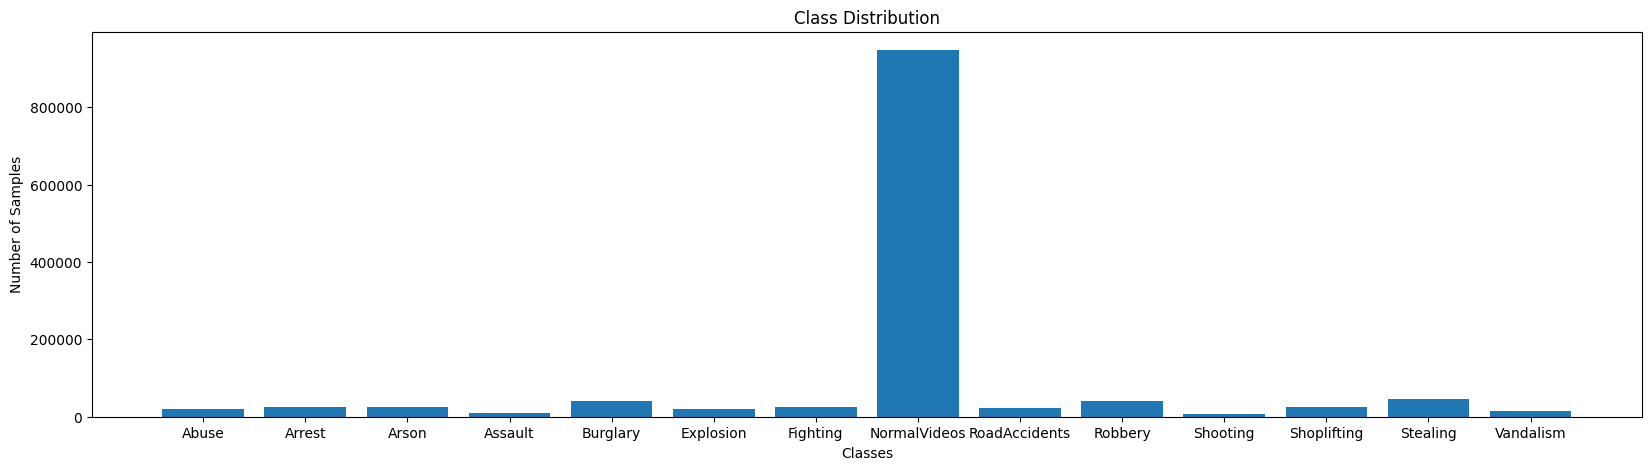

In [29]:
#Visualisation
dataset_path = '/content/Train/'
num_samples=14
class_folders = [folder for folder in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, folder))]
class_counts = Counter()
for classes in class_names:
    class_path = os.path.join(dataset_path, classes)
    class_counts[classes] = len(os.listdir(class_path))
classes, counts = zip(*class_counts.items())
dcount = dict()
i=0
for crimes in classes:
  dcount[crimes] = counts[i]
  i=i+1

print(dcount)
plt.figure(figsize=(20,5))  # Set the figsize here
plt.bar(classes, counts)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Class Distribution')
plt.show()



The data is imbalanced due to a huge amount of samples belonging to the class 'NormalVideos'

##Model Building

In [30]:
from keras.applications.mobilenet_v2 import MobileNetV2

In [31]:
mobilenet_v2 = MobileNetV2(
    input_shape=(64, 64, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=14,
    classifier_activation='softmax'
)


for layer in mobilenet_v2.layers:
    layer.trainable = False

optimizer = SGD(learning_rate=0.001)

model = Sequential()
model.add(mobilenet_v2)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(1024, activation='relu'))
model.add(Dense(len(class_names), activation='softmax'))

# Display model summary
model.summary()

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 2, 2, 1280)        2257984   
 tional)                                                         
                                                                 
 module_wrapper_21 (ModuleW  (None, 5120)              0         
 rapper)                                                         
                                                                 
 module_wrapper_22 (ModuleW  (None, 256)               1310976   
 rapper)                                                         
                                                                 
 batch_normalization_6 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 module_wrapper_23 (ModuleW  (None, 256)              

##Training the Model

In [32]:
#Checkpoint used to save the best performances only
checkpoint = ModelCheckpoint(
    filepath='crime.h5',
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=1)

from keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_schedule = LearningRateScheduler(scheduler)


In [33]:
#training the model (taking a lotttt of time, but it works)
callbacks = [checkpoint]
epochs=10

#Manually setting the priority of 'NormalVideos' (majority) class
#to balance the dataset
class_weight = {0: 1,
                1: 1,
                2: 1,
                3: 1,
                4: 1,
                5: 1,
                6: 1,
                7: 0.7,
                8: 1,
                9: 1,
                10: 1,
                11: 1,
                12: 1,
                13: 1,}

model_history = model.fit(
  train_set,
  validation_data=test_set,
  epochs=epochs,
  steps_per_epoch = 100,
  callbacks=callbacks,
  # class_weight = class_weight
)

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 1.4299 - accuracy: 0.6900
Epoch 1: val_loss improved from inf to 3.14930, saving model to crime.h5
100/100 [==============================] - 731s 7s/step - loss: 1.4299 - accuracy: 0.6900 - val_loss: 3.1493 - val_accuracy: 0.4037
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 1.2662 - accuracy: 0.7228
Epoch 2: val_loss improved from 3.14930 to 2.31910, saving model to crime.h5
100/100 [==============================] - 771s 8s/step - loss: 1.2662 - accuracy: 0.7228 - val_loss: 2.3191 - val_accuracy: 0.4849
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 1.2276 - accuracy: 0.7178
Epoch 3: val_loss improved from 2.31910 to 2.28730, saving model to crime.h5
100/100 [==============================] - 710s 7s/step - loss: 1.2276 - accuracy: 0.7178 - val_loss: 2.2873 - val_accuracy: 0.5766
Epoch 4/10
100/100 [==============================] - ETA: 0s - loss: 1.1405 - accuracy: 

##Testing the Model

In [ ]:
from keras.models import load_model

mobilenet_v2 = MobileNetV2(
    input_shape=(64, 64, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    pooling=None,
    classes=14,
    classifier_activation='softmax'
)


for layer in mobilenet_v2.layers:
    layer.trainable = False

optimizer = Adam(learning_rate=0.001)

model_predict = Sequential()
model_predict.add(mobilenet_v2)
model_predict.add(Flatten())
model_predict.add(Dense(256, activation='relu'))
model_predict.add(BatchNormalization())
model_predict.add(Dropout(0.2))
model_predict.add(Dense(512, activation='relu'))
model_predict.add(BatchNormalization())
model_predict.add(Dropout(0.2))
model_predict.add(Dense(1024, activation='relu'))
model_predict.add(Dense(len(class_names), activation='softmax'))
model_predict.load_weights('crime.h5')

In [35]:
#Running the model on a single image
from keras.utils import load_img
img = image.load_img('/content/Test/NormalVideos/Normal_Videos_003_x264_2200.png',target_size=(64,64))
x=image.img_to_array(img)
x=np.expand_dims(x,axis=0)
prediction = np.argmax(model_predict.predict(x))
class_names[prediction]

1/1 [==============================] - 1s 1s/step


'NormalVideos'

In [36]:
#Running the model on Test_set
predictions = model_predict.predict(test_set)
predicted_labels = np.argmax(predictions, axis=1)

3479/3479 [==============================] - 699s 201ms/step


##Evaluating the Model

In [ ]:
true_labels = test_set.classes

In [39]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy * 100:.2f}%')

precision = precision_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
recall = recall_score(true_labels, np.argmax(predictions, axis=1), average='weighted')
f1 = f1_score(true_labels, np.argmax(predictions, axis=1), average='weighted')

print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1-score: {f1 * 100:.2f}%')

# Print classification report
print('Classification Report:')
print(classification_report(true_labels, np.argmax(predictions, axis=1)))

# Print confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(true_labels, np.argmax(predictions, axis=1)))

Accuracy: 54.59%
Precision: 35.09%
Recall: 54.59%
F1-score: 42.07%
Classification Report:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.03      0.00      0.01       297
           1       0.00      0.00      0.00      3365
           2       0.03      0.02      0.02      2793
           3       0.00      0.00      0.00      2657
           4       0.00      0.00      0.00      7657
           5       0.06      0.00      0.01      6510
           6       0.00      0.00      0.00      1231
           7       0.58      0.93      0.72     64952
           8       0.00      0.00      0.00      2663
           9       0.01      0.00      0.00       835
          10       0.00      0.00      0.00      7630
          11       0.08      0.00      0.00      7623
          12       0.01      0.04      0.02      1984
          13       0.00      0.00      0.00      1111

    accuracy                           0.55    111308
   macro avg       0.06      0.07      0.06    111308
weighted avg       0.35      0.55      0.42    111308

Confusion Matrix:
[[    1

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
